# M2 Written Exam

### Group: AAE


*   amogha25@student.aau.dk
*   alang22@student.aau.dk
* egraca22@student.aau.dk

Github repository link: https://github.com/houlie3/M2-Exam-AAE

Choosen dataset: S&P 500 earnings call transcripts




In this cell, we install all required Python libraries (pandas, networkx, seaborn, spacy, etc.), import the necessary modules, and configure the Gemini API using our stored API key. This prepares the environment for data processing, LLM extraction, and network analysis in the following steps.

In [26]:
# Install dependencies
!pip install pandas networkx matplotlib seaborn datasets tqdm spacy sentence-transformers umap-learn scikit-learn plotly

import os
import json
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import time

# Gemini API setup
from openai import OpenAI
from google.colab import userdata

api_key = userdata.get("GEMINI_API_KEY")
if not api_key:
    raise ValueError("⚠️ Set GEMINI_API_KEY in Colab secrets")

client = OpenAI(
    api_key=api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)


In this cell, we load the S&P 500 earnings call transcript dataset, shuffle it with a fixed seed to ensure reproducibility, and select a small subset of 20 transcripts for analysis. We also print the company ticker symbols to verify that the sampling is random.

In [3]:
dataset = load_dataset("kurry/sp500_earnings_transcripts", split="train")
# Shuffle the dataset with a fixed seed for reproducibility
shuffled_dataset = dataset.shuffle(seed=42)

# Select 20 random entries and convert to mutable list of dicts
subset = [dict(item) for item in shuffled_dataset.select(range(20))]

# Check the symbols to confirm randomness
for i, item in enumerate(subset):
    print(i, item['symbol'])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

parquet_files/part-0.parquet:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33362 [00:00<?, ? examples/s]

0 VLO
1 REGN
2 CTAS
3 YUM
4 WHR
5 ETN
6 CVX
7 APA
8 CBRE
9 CPAY
10 NDSN
11 O
12 AXON
13 EA
14 COF
15 ABBV
16 NLSN
17 WEC
18 EBAY
19 SBAC


In [4]:
print(dataset)

Dataset({
    features: ['symbol', 'quarter', 'year', 'date', 'content', 'structured_content', 'company_name', 'company_id'],
    num_rows: 33362
})


In this cell, we use the spaCy NLP model to scan each transcript and extract only the sentences that contain predefined risk-related keywords (e.g., “risk”, “compliance”, “fraud”, “breach”, etc.). We store these filtered sentences in the dataset as filtered_text, reducing the transcript length and keeping only the most relevant content for the LLM extraction step.

In [5]:
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Define your risk-related keywords
risk_keywords = {
    # General risk
    "risk", "hazard", "danger", "threat", "incident", "accident",
    "exposure", "harm", "injury", "loss", "failure", "vulnerability",
    "unsafe", "emergency", "disaster", "mitigation", "prevention",

    # Workplace & safety
    "safety", "violation", "compliance", "inspection", "protocol",
    "control", "equipment", "protective", "training", "audit",
    "hazardous", "containment",

    # Financial
    "liability", "insurance", "fraud", "default", "volatility",
    "uncertainty", "instability", "debt", "bankruptcy",

    # Cybersecurity
    "breach", "malware", "attack", "compromise", "intrusion",
    "unauthorized", "encryption", "security", "ransomware",

    # Health & environmental
    "toxic", "contamination", "pollution", "infection", "disease",
    "chemical", "spill", "evacuation", "outbreak"
}

# Convert to lowercase for case-insensitive matching
risk_keywords = set([kw.lower() for kw in risk_keywords])

for i, item in enumerate(subset):
    text = item["content"][:5000]
    doc = nlp(text)

    risk_sentences = [
        sent.text.strip()
        for sent in doc.sents
        if any(kw in sent.text.lower() for kw in risk_keywords)
    ]

    filtered_text = " ".join(risk_sentences)

    # Save it into the SAME subset
    item["filtered_text"] = filtered_text

    char_len = len(filtered_text)
    word_len = len(filtered_text.split())

    print(f"Transcript {i}: {char_len} characters, {word_len} words (risk-related only)")
    print(f"→ Sentences kept: {len(risk_sentences)}")
    print("-" * 80)

Transcript 0: 436 characters, 74 words (risk-related only)
→ Sentences kept: 3
--------------------------------------------------------------------------------
Transcript 1: 1260 characters, 187 words (risk-related only)
→ Sentences kept: 8
--------------------------------------------------------------------------------
Transcript 2: 628 characters, 90 words (risk-related only)
→ Sentences kept: 4
--------------------------------------------------------------------------------
Transcript 3: 180 characters, 27 words (risk-related only)
→ Sentences kept: 1
--------------------------------------------------------------------------------
Transcript 4: 98 characters, 15 words (risk-related only)
→ Sentences kept: 1
--------------------------------------------------------------------------------
Transcript 5: 406 characters, 68 words (risk-related only)
→ Sentences kept: 2
--------------------------------------------------------------------------------
Transcript 6: 377 characters, 66 words 

This cell prints the character length of the filtered_text for each transcript, allowing us to confirm that the spaCy filtering step successfully extracted risk-related sentences and that no entries are empty.

In [6]:
for i, item in enumerate(subset):
    print(f"{i}: filtered_text length={len(item.get('filtered_text',''))}")



0: filtered_text length=436
1: filtered_text length=1260
2: filtered_text length=628
3: filtered_text length=180
4: filtered_text length=98
5: filtered_text length=406
6: filtered_text length=377
7: filtered_text length=167
8: filtered_text length=719
9: filtered_text length=444
10: filtered_text length=625
11: filtered_text length=885
12: filtered_text length=662
13: filtered_text length=146
14: filtered_text length=259
15: filtered_text length=290
16: filtered_text length=686
17: filtered_text length=1663
18: filtered_text length=518
19: filtered_text length=140


This cell defines the complete pipeline for extracting structured risk information with Gemini.
It includes:

* clean_json(): Safely extracts a JSON array from the model’s output.

* call_gemini_with_retry(): Sends prompts to Gemini with automatic retries if the model is overloaded.

* extract_risks_gemini_full_text(): Sends each transcript’s filtered risk-related text to Gemini and receives structured risk objects (company, risk_type, sentence).

* process_transcripts_filtered(): Loops through all transcripts, runs extraction, and aggregates all detected risks.

This is the core step where the LLM converts unstructured text into structured data for further analysis.

In [7]:
import re
import json
import time
from tqdm import tqdm

# --- JSON cleaning ---
def clean_json(text):
    """Extracts the first JSON array from LLM output, ignoring extra text."""
    match = re.search(r"\[.*\]", text, flags=re.DOTALL)
    if match:
        try:
            return json.loads(match.group(0))
        except json.JSONDecodeError:
            return []
    return []

# --- Gemini call with retry ---
def call_gemini_with_retry(prompt, model="gemini-2.5-flash", max_retries=5, wait_time=5):
    """Call Gemini API safely with retries on overload."""
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )
            return response.choices[0].message.content
        except Exception as e:
            err_msg = str(e)
            if "503" in err_msg or "UNAVAILABLE" in err_msg:
                print(f"⚠️ Model overloaded, retrying in {wait_time}s... (attempt {attempt+1}/{max_retries})")
                time.sleep(wait_time)
                wait_time *= 2
            else:
                print("❌ Unexpected error:", e)
                return None
    print("❌ Max retries exceeded.")
    return None

# --- Risk extraction without further chunking ---
def extract_risks_gemini_full_text(filtered_text, company_name, model="gemini-2.5-flash"):
    """
    Sends the already filtered transcript to Gemini without splitting into chunks.
    Returns a list of dictionaries.
    """
    all_risks = []

    if not filtered_text.strip():
        return all_risks  # skip empty filtered text

    prompt = f"""
    Extract all risks mentioned in the following earnings transcript.
    For each risk, provide a JSON array where each element is an object with keys:
    "company": "{company_name}",
    "risk_type": type of risk discussed (e.g., market, operational, regulatory, legal, supply chain),
    "sentence": the exact sentence mentioning it.
    Your entire response must be a valid JSON array, with no extra text.

    Text: {filtered_text}
    """
    content = call_gemini_with_retry(prompt, model=model)
    if content:
        risks_chunk = clean_json(content)
        all_risks.extend(risks_chunk)

    return all_risks

# --- Main Loop ---
def process_transcripts_filtered(subset, model="gemini-2.5-flash", output_path="all_risks_extracted.json", delay_seconds=22):
    """
    Processes multiple transcripts sequentially with an enforced delay between API calls
    to respect Gemini free-tier rate limits (≈10 requests/minute).
    """
    all_risks = []

    for i, item in enumerate(tqdm(subset, desc="Processing transcripts")):
        company = item.get("symbol", f"Transcript_{i}")
        filtered_text = item.get("filtered_text", "").strip()

        if not filtered_text:
            print(f"⚠️ No risk sentences found for {company}")
            continue

        # Extract risks from the filtered text
        risks = extract_risks_gemini_full_text(filtered_text, company, model=model)
        all_risks.extend(risks)

        # Add delay to prevent hitting rate limits
        # Can be outcommented if you got a great API:)
        print(f"⏳ Waiting {delay_seconds}s before next request to respect rate limits...")
        time.sleep(delay_seconds)

    print("=" * 80)
    print(f"✅ Extraction complete: {len(all_risks)} total risks found across {len(subset)} transcripts.")
    print("=" * 80)

    return all_risks



This cell executes the full Gemini extraction pipeline on the filtered transcripts. It processes each item in the subset, sends the risk-related text to the LLM, and collects all extracted risk objects into the all_risks list.

In [8]:
all_risks = process_transcripts_filtered(subset)

Processing transcripts:   0%|          | 0/20 [00:00<?, ?it/s]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:   5%|▌         | 1/20 [00:28<08:54, 28.13s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  10%|█         | 2/20 [00:57<08:35, 28.61s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  15%|█▌        | 3/20 [01:24<07:58, 28.12s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  20%|██        | 4/20 [01:52<07:30, 28.18s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  25%|██▌       | 5/20 [02:17<06:44, 26.95s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  30%|███       | 6/20 [02:44<06:18, 27.01s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  35%|███▌      | 7/20 [03:08<05:39, 26.09s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  40%|████      | 8/20 [03:33<05:07, 25.61s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  45%|████▌     | 9/20 [04:00<04:46, 26.08s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  50%|█████     | 10/20 [04:38<04:55, 29.60s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  55%|█████▌    | 11/20 [05:14<04:43, 31.53s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  60%|██████    | 12/20 [05:40<04:01, 30.13s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  65%|██████▌   | 13/20 [06:16<03:43, 31.87s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  70%|███████   | 14/20 [06:41<02:58, 29.76s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  75%|███████▌  | 15/20 [07:09<02:25, 29.10s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  80%|████████  | 16/20 [07:35<01:53, 28.25s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  85%|████████▌ | 17/20 [08:06<01:27, 29.01s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  90%|█████████ | 18/20 [08:30<00:55, 27.62s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts:  95%|█████████▌| 19/20 [09:09<00:31, 31.08s/it]

⏳ Waiting 22s before next request to respect rate limits...


Processing transcripts: 100%|██████████| 20/20 [09:34<00:00, 28.73s/it]

✅ Extraction complete: 22 total risks found across 20 transcripts.


In this cell, we convert the extracted LLM outputs into a pandas DataFrame and remove duplicate risk entries (same company, risk type, and sentence). This produces a clean structured dataset (df_risks) that we use for all subsequent analysis and visualization.

In [27]:
df_risks = pd.DataFrame(all_risks)

# Remove duplicates
df_risks.drop_duplicates(subset=["company", "risk_type", "sentence"], inplace=True)

print("Number of risks extracted:", len(df_risks))
df_risks.head()


Number of risks extracted: 21


,company,risk_type,sentence
0,VLO,Financial,As noted in the release we reported a first qu...
1,VLO,Financial,I should note that the $12 million aftertax lo...
2,VLO,Financial,The first quarter 2010 operating loss was $32 ...
3,REGN,General Business/Financial,Each forward-looking statement is subject to r...
4,REGN,Market/Competitive,"EYLEA sets a high bar on efficacy, safety, dos..."


This cell computes basic descriptive statistics on the extracted risks, including how many risks each company mentions and which risk types occur most frequently. It then visualizes the top risk types using a countplot, giving an overview of the dominant themes in the dataset.

This code takes the structured risk data extracted from company transcripts by the LLM pipeline and adds a semantic analysis layer using embeddings and clustering.

Generate Embeddings
The SentenceTransformer converts each sentence into a numerical vector
Cluster the Embeddings (KMeans)
The algorithm groups semantically similar sentences together into clusters
Dimensionality Reduction (UMAP)
UMAP reduces them to two dimensions

Cluster Summaries
The code prints a few example sentences from each cluster, giving you a quick qualitative sense of what each semantic group represents (e.g., financial risk, supply chain issues, cybersecurity).

🔍 Generating embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



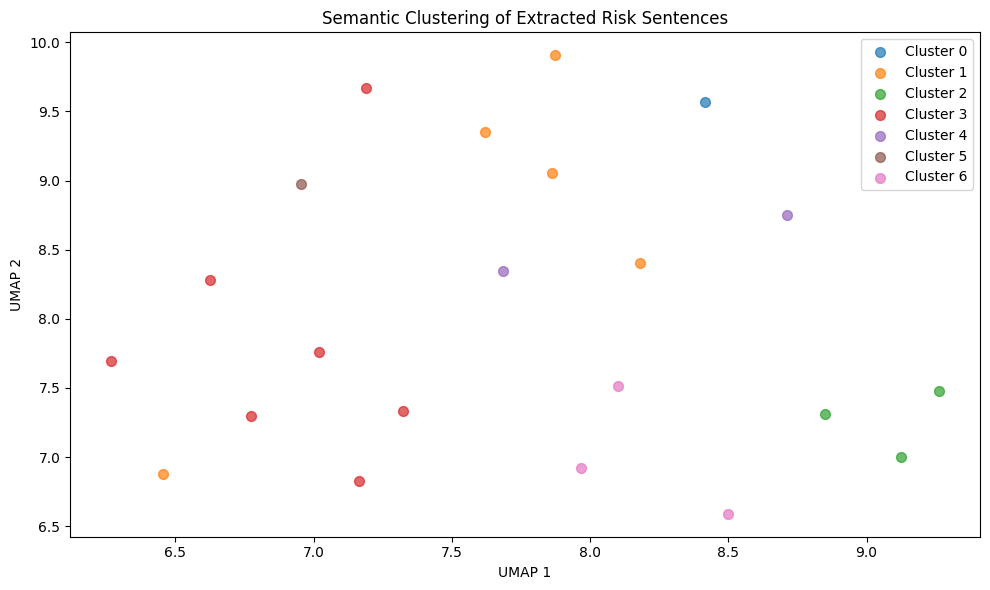


🧠 Cluster summaries:

Cluster 0 (1 items):
  • ETN - Financial Performance - Our actual results may differ materially from our forecasts or projections due to a wide r...

Cluster 1 (5 items):
  • CTAS - operational - We will pursue business interruption insurance recovery according to our policies in effect....
  • CPAY - Operational - So first was safety....
  • NDSN - General Business Risk - These statements may involve a number of risks, uncertainties, and other factors as discu...

Cluster 2 (3 items):
  • VLO - Financial - As noted in the release we reported a first quarter 2010 loss from continuing operations of $101 milli...
  • VLO - Financial - I should note that the $12 million aftertax loss from discontinued operations shown in the financials ...
  • VLO - Financial - The first quarter 2010 operating loss was $32 million versus $593 million of operating income in the f...

Cluster 3 (7 items):
  • REGN - General Business/Financial - Each forward-looking statement is subjec

In [31]:
# --- Semantic Embeddings + Clustering + Visualization ---
# (Run this AFTER your LLM extraction pipeline)

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt

# --- Step 1: Convert structured risk data to text form ---
texts = [
    f"{r.get('company','UNKNOWN')} - {r.get('risk_type','unspecified')} - {r.get('sentence','')}"
    for r in all_risks
    if r.get('sentence')
]

if not texts:
    raise ValueError("No risk sentences found in all_risks. Ensure your pipeline extracted data before this step.")

# --- Step 2: Generate embeddings ---
print("🔍 Generating embeddings...")
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(texts, show_progress_bar=True)

# --- Step 3: Semantic clustering ---
n_clusters = min(10, len(texts) // 3 or 1)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# --- Step 4: Dimensionality reduction ---
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# --- Step 5: Plot static scatter plot ---
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    idxs = cluster_labels == cluster
    plt.scatter(
        embedding_2d[idxs, 0],
        embedding_2d[idxs, 1],
        label=f"Cluster {cluster}",
        alpha=0.7,
        s=50
    )

plt.title("Semantic Clustering of Extracted Risk Sentences")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.tight_layout()
plt.show()

# --- Step 6: Cluster summary ---
print("\n🧠 Cluster summaries:")
for c in sorted(np.unique(cluster_labels)):
    sample_texts = [texts[i] for i in range(len(texts)) if cluster_labels[i] == c][:3]
    print(f"\nCluster {c} ({sum(cluster_labels==c)} items):")
    for t in sample_texts:
        print(f"  • {t[:120]}...")



Visualization (Plotly Scatter Plot)
Each point in the scatter plot represents one extracted risk sentence:

Position (x, y) → semantic similarity (closer points = more similar meaning)
Color → cluster membership (grouped by KMeans)

The scatter plot reveals semantic relationships among all extracted risk sentences.
* Tightly grouped clusters indicate that the LLM identified similar risks across multiple companies.
* Widely spread clusters suggest a diverse set of risk discussions.
* The number and density of clusters provide a quick visual summary of how varied or concentrated the risk landscape is across your sample.

In this cell, we construct a bipartite network where companies and risk types are represented as nodes. An edge is added whenever a company mentions a given risk type in its earnings transcript. We restrict the graph to the top 25 most frequent risk types to keep the visualization readable.

Node colors:

🟢 Green nodes represent companies

🔵 Blue nodes represent risk types

A spring layout is used to position the nodes, making clusters and strong associations easier to interpret.

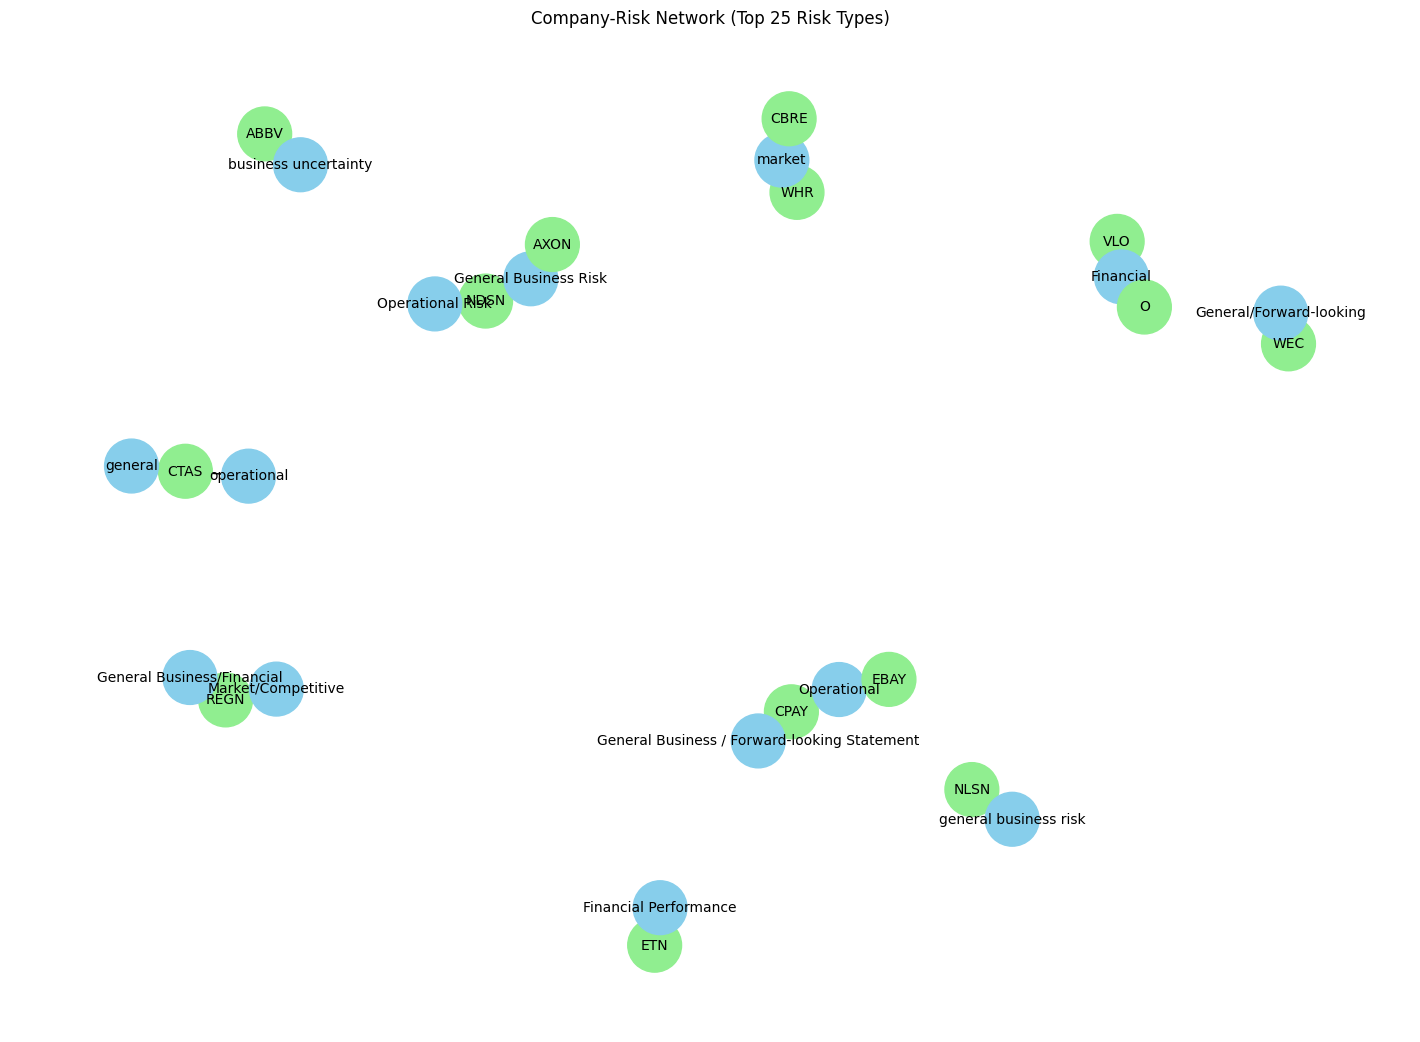

In [11]:
# Get top 25 risk types
top_25_risks = df_risks['risk_type'].value_counts().head(25).index

# Filter dataframe to only include top 25 risks
df_top25 = df_risks[df_risks['risk_type'].isin(top_25_risks)]

# Build network graph
G = nx.Graph()
for _, row in df_top25.iterrows():
    G.add_node(row['company'], type='company')
    G.add_node(row['risk_type'], type='risk')
    G.add_edge(row['company'], row['risk_type'], sentence=row['sentence'])

# Visualize
plt.figure(figsize=(14,10))
pos = nx.spring_layout(G, seed=42)
node_colors = ['lightgreen' if G.nodes[n].get('type')=='company' else 'skyblue' for n in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1500, font_size=10)
plt.title("Company-Risk Network (Top 25 Risk Types)")
plt.show()



**Interpretation**

The network shows small, disconnected clusters because each company mentions only a few risks in the filtered transcripts. Green nodes are companies and blue nodes are risk types. Each mini-cluster represents one company and the specific risks it discussed (e.g., REGN focuses on competitive and financial risks, CPAY on operational risks, VLO/CTAS on financial + operational). Because the sample is small, there are no shared risks forming larger connected groups.

This cell performs basic network analysis on the company–risk graph:

* Degree centrality: Identifies the most connected nodes (companies or risks that appear most frequently).

* Betweenness centrality: Finds nodes that act as bridges between others (important connectors in the network).

* Community detection: Uses modularity to group companies and risks into meaningful clusters based on shared connections.

This helps identify which risks are most central, which companies discuss the most diverse risks, and whether any natural communities form in the dataset.

In [12]:
# Degree centrality
deg_centrality = nx.degree_centrality(G)
top_nodes = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top nodes by degree centrality:", top_nodes)

# Betweenness centrality
btw_centrality = nx.betweenness_centrality(G)
top_btw = sorted(btw_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top nodes by betweenness centrality:", top_btw)

# Community detection (optional)
from networkx.algorithms.community import greedy_modularity_communities
communities = list(greedy_modularity_communities(G))
for i, comm in enumerate(communities):
    print(f"Community {i+1}: {comm}")


Top nodes by degree centrality: [('Financial', 0.07407407407407407), ('REGN', 0.07407407407407407), ('CTAS', 0.07407407407407407), ('market', 0.07407407407407407), ('CPAY', 0.07407407407407407), ('Operational', 0.07407407407407407), ('NDSN', 0.07407407407407407), ('General Business Risk', 0.07407407407407407), ('VLO', 0.037037037037037035), ('General Business/Financial', 0.037037037037037035)]
Top nodes by betweenness centrality: [('CPAY', 0.005698005698005698), ('Operational', 0.005698005698005698), ('NDSN', 0.005698005698005698), ('General Business Risk', 0.005698005698005698), ('Financial', 0.002849002849002849), ('REGN', 0.002849002849002849), ('CTAS', 0.002849002849002849), ('market', 0.002849002849002849), ('VLO', 0.0), ('General Business/Financial', 0.0)]
Community 1: frozenset({'General Business / Forward-looking Statement', 'Operational', 'EBAY', 'CPAY'})
Community 2: frozenset({'Operational Risk', 'AXON', 'General Business Risk', 'NDSN'})
Community 3: frozenset({'Financial', 

This cell attaches year and company metadata to each extracted risk.

* It builds a small table with the symbol, company name, and year from the original transcript subset.

* It merges this metadata into df_risks, so each risk inherits the correct year.

* If duplicate merge columns appear (e.g., year_x / year_y), they are cleaned into a single year column.
This prepares the dataset for time-based analysis (e.g., comparing risks before/after certain years).

In [13]:
# Build meta (ticker -> year, company_name) from your existing subset list
meta_rows = []
for it in subset:
    meta_rows.append({
        "company": it.get("symbol"),      # you used 'symbol' as company in extraction
        "year": it.get("year"),
        "company_name": it.get("company_name")
    })
meta_df = pd.DataFrame(meta_rows).drop_duplicates()

# Merge into df_risks
df_risks = df_risks.merge(meta_df, on="company", how="left")

# If duplicates from an earlier merge exist, collapse to a single 'year'
if "year_x" in df_risks.columns and "year_y" in df_risks.columns:
    df_risks["year"] = df_risks["year_y"].fillna(df_risks["year_x"])
    df_risks.drop(columns=["year_x","year_y"], inplace=True)

print("Columns now:", df_risks.columns.tolist())
print("Years present:", sorted(df_risks["year"].dropna().unique().tolist()) if "year" in df_risks else "no year")


Columns now: ['company', 'risk_type', 'sentence', 'year', 'company_name']
Years present: [2009, 2010, 2013, 2014, 2015, 2016, 2018, 2020, 2022, 2023, 2024]


This cell standardizes the extracted risk types to make the analysis more consistent.

* It normalizes risk labels (lowercasing, trimming).

* It assigns each risk to a broader category (e.g., market/financial, cybersecurity, regulatory/legal) using simple keyword rules.

* This makes it easier to group, compare, and visualize risks across companies.

In [14]:
# Normalize risk types (lowercase, trim) and map synonyms to buckets
df_risks["risk_type_norm"] = (
    df_risks["risk_type"]
      .astype(str)
      .str.strip()
      .str.lower()
)

# Simple keyword-based category
def risk_category(rt: str) -> str:
    if any(k in rt for k in ["regulator", "compliance", "antitrust", "legal"]):
        return "regulatory/legal"
    if any(k in rt for k in ["market", "demand", "pricing", "macroecon", "inflation", "volatility", "currency"]):
        return "market/financial"
    if any(k in rt for k in ["supply", "logistic", "production", "manufactur"]):
        return "supply/operations"
    if any(k in rt for k in ["cyber", "security", "ransom", "breach", "attack"]):
        return "cybersecurity"
    if any(k in rt for k in ["reputation", "brand", "sentiment"]):
        return "reputation"
    if any(k in rt for k in ["health", "environment", "pollut", "toxic", "disease", "outbreak"]):
        return "health/environment"
    return "other"

df_risks["risk_category"] = df_risks["risk_type_norm"].apply(risk_category)

# Quick check
print(df_risks[["company","risk_type","risk_type_norm","risk_category"]].head(8))

  company                   risk_type              risk_type_norm  \
0     VLO                   Financial                   financial   
1     VLO                   Financial                   financial   
2     VLO                   Financial                   financial   
3    REGN  General Business/Financial  general business/financial   
4    REGN          Market/Competitive          market/competitive   
5    CTAS                 operational                 operational   
6    CTAS                     general                     general   
7     WHR                      market                      market   

      risk_category  
0             other  
1             other  
2             other  
3             other  
4  market/financial  
5             other  
6             other  
7  market/financial  


This cell creates descriptive visualizations of the extracted risks.

* It shows the most frequent normalized risk types in a horizontal bar chart.

* It also plots the distribution of broader risk categories (e.g., regulatory, market, cybersecurity).
These plots help us understand which types of risks dominate the transcripts.

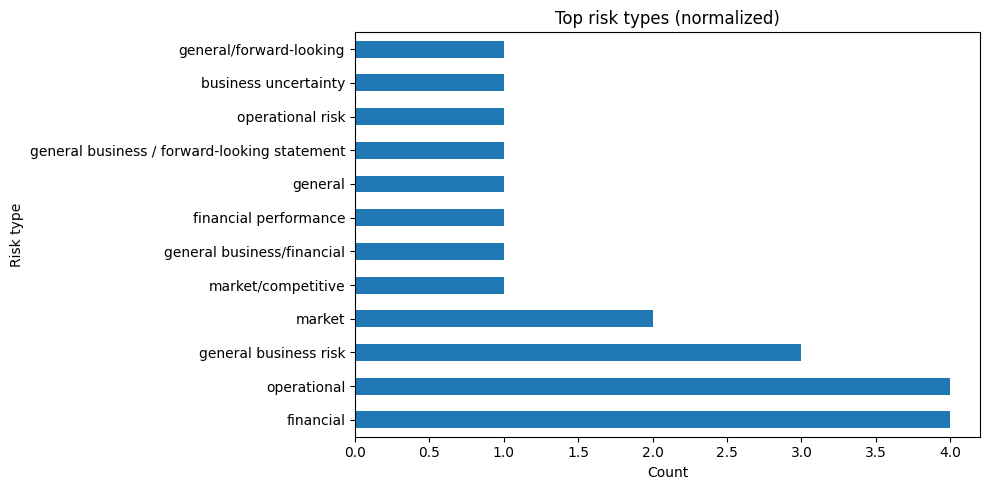

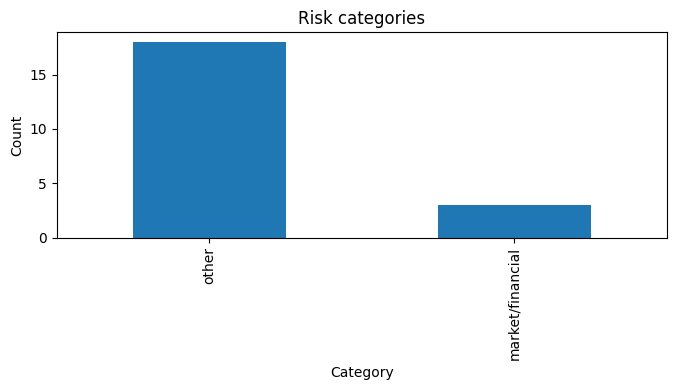

In [15]:
# Counts by normalized type and by category
top_types = df_risks["risk_type_norm"].value_counts().head(15)
top_cats  = df_risks["risk_category"].value_counts()

fig, ax = plt.subplots(figsize=(10,5))
top_types.plot(kind="barh", ax=ax)
ax.set_title("Top risk types (normalized)")
ax.set_xlabel("Count"); ax.set_ylabel("Risk type")
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(7,4))
top_cats.plot(kind="bar", ax=ax)
ax.set_title("Risk categories")
ax.set_xlabel("Category"); ax.set_ylabel("Count")
plt.tight_layout(); plt.show()

This cell performs a manual quality check of the LLM extraction. It randomly selects 3 extracted risks and prints the company, year, risk type, risk category, and the exact sentence the model returned. This helps evaluate whether the LLM’s outputs are accurate and meaningful.

In [16]:
print("🧐 Manual inspection: 3 random extractions")
sample = df_risks.sample(min(3, len(df_risks)), random_state=7)
for _, r in sample.iterrows():
    print("\n—"*32)
    print("Ticker:", r["company"], "| Year:", r.get("year"))
    print("Risk type:", r["risk_type"])
    print("Category:", r["risk_category"])
    print("Extracted sentence:", r["sentence"][:400], "...")

🧐 Manual inspection: 3 random extractions

—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
Ticker: VLO | Year: 2010
Risk type: Financial
Category: other
Extracted sentence: I should note that the $12 million aftertax loss from discontinued operations shown in the financials tables relates to the Delaware City assets that were shut down in the fourth quarter. ...

—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
Ticker: CTAS | Year: 2009
Risk type: operational
Category: other
Extracted sentence: We will pursue business interruption insurance recovery according to our policies in effect. ...

—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
—
Ticker: VLO | Year: 2010
Risk type: Financial
Category: other
Extracted sentence: The first quarter 2010 operating loss was $32 million versus $593 million of operating income in the first quarter of 2009. ...


This cell builds a weighted bipartite network where edges represent how many times a company mentions a specific normalized risk type.

* It creates an edge list with weights (frequency of co-occurrence).

* It constructs separate node tables for companies and risks, including attributes like company name, year, and risk category.

* It then builds the weighted graph Gw and saves all node and edge tables as CSV files for documentation and reproducibility.

In [17]:
# Weighted edgelist (company — risk_type_norm)
edges = (
    df_risks.groupby(["company","risk_type_norm"], as_index=False)
            .size()
            .rename(columns={"size":"weight"})
)
# Nodes tables
companies = df_risks[["company","company_name","year"]].drop_duplicates().rename(columns={"company":"node"})
risks     = df_risks[["risk_type_norm","risk_category"]].drop_duplicates().rename(columns={"risk_type_norm":"node"})

# Build graph with weights + attributes
Gw = nx.Graph()
for _, row in companies.iterrows():
    Gw.add_node(row["node"], type="company", company_name=row.get("company_name"))
for _, row in risks.iterrows():
    Gw.add_node(row["node"], type="risk", risk_category=row.get("risk_category"))

for _, row in edges.iterrows():
    Gw.add_edge(row["company"], row["risk_type_norm"], weight=row["weight"])

print(f"Weighted graph: {Gw.number_of_nodes()} nodes, {Gw.number_of_edges()} edges")

# Export CSVs for deliverables
edges.to_csv("edgelist_company_risk_weighted.csv", index=False)
companies.to_csv("nodes_companies.csv", index=False)
risks.to_csv("nodes_risks.csv", index=False)
print("Saved: edgelist_company_risk_weighted.csv, nodes_companies.csv, nodes_risks.csv")

Weighted graph: 26 nodes, 18 edges
Saved: edgelist_company_risk_weighted.csv, nodes_companies.csv, nodes_risks.csv


This cell visualizes the weighted company–risk network built earlier.

* Green nodes represent companies, blue nodes represent risk types.

* Edge thickness increases with the weight (how often a company mentions a risk).

* The spring layout highlights which risks are most strongly associated with which companies.
It also runs a community detection algorithm to identify clusters of companies and risks that are closely related.

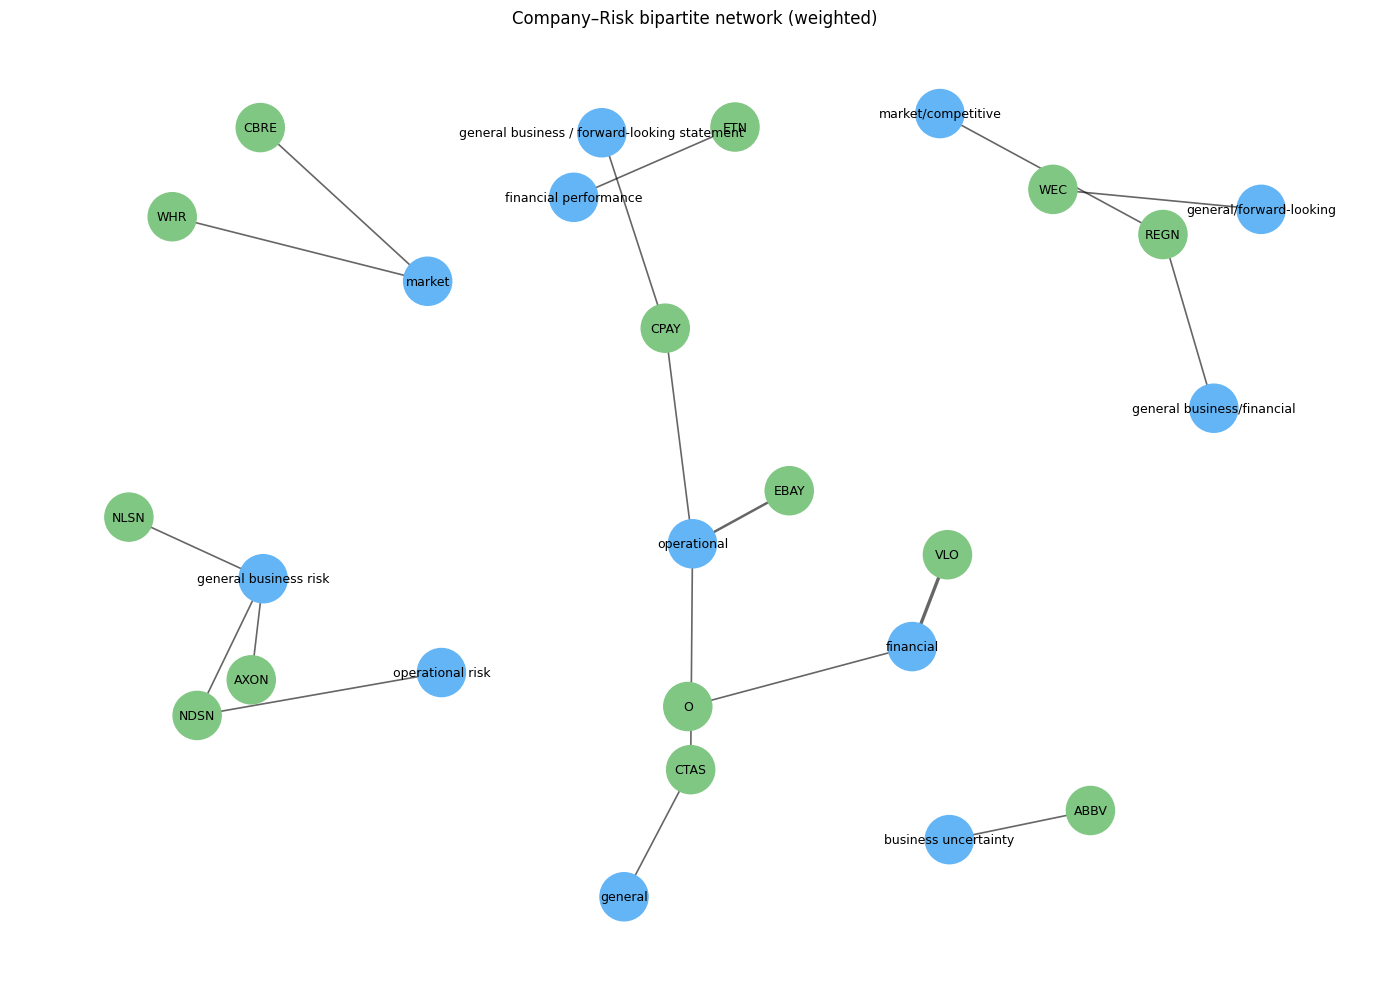

Detected 8 communities.


In [18]:
plt.figure(figsize=(14,10))
pos = nx.spring_layout(Gw, seed=42, k=0.6)

node_colors = ["#81C784" if Gw.nodes[n]["type"]=="company" else "#64B5F6" for n in Gw.nodes()]
edge_ws = [0.6 + 0.6*Gw[u][v]["weight"] for u,v in Gw.edges()]  # thicker if more co-mentions

nx.draw_networkx_nodes(Gw, pos, node_color=node_colors, node_size=1200)
nx.draw_networkx_labels(Gw, pos, font_size=9)
nx.draw_networkx_edges(Gw, pos, width=edge_ws, alpha=0.6)
plt.title("Company–Risk bipartite network (weighted)")
plt.axis("off"); plt.tight_layout(); plt.show()

# Communities on bipartite graph (greedy)
from networkx.algorithms.community import greedy_modularity_communities
comms = list(greedy_modularity_communities(Gw))
print(f"Detected {len(comms)} communities.")


This cell creates a company–company projection of the bipartite network.

* Two companies are connected if they share one or more risk types.

* Edge weights represent how many risks they have in common.

* It prints the most strongly connected companies and visualizes the network, showing which companies have similar risk profiles.
This helps identify firms that face similar types of risks or operate in comparable environments.

Company–Company projection: 14 nodes, 8 edges
Top companies by shared-risk connectivity: [('CTAS', 2), ('CPAY', 2), ('NDSN', 2), ('AXON', 2), ('NLSN', 2), ('EBAY', 2), ('VLO', 1), ('WHR', 1), ('CBRE', 1), ('O', 1)]


/tmp/ipython-input-2279469547.py:21: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



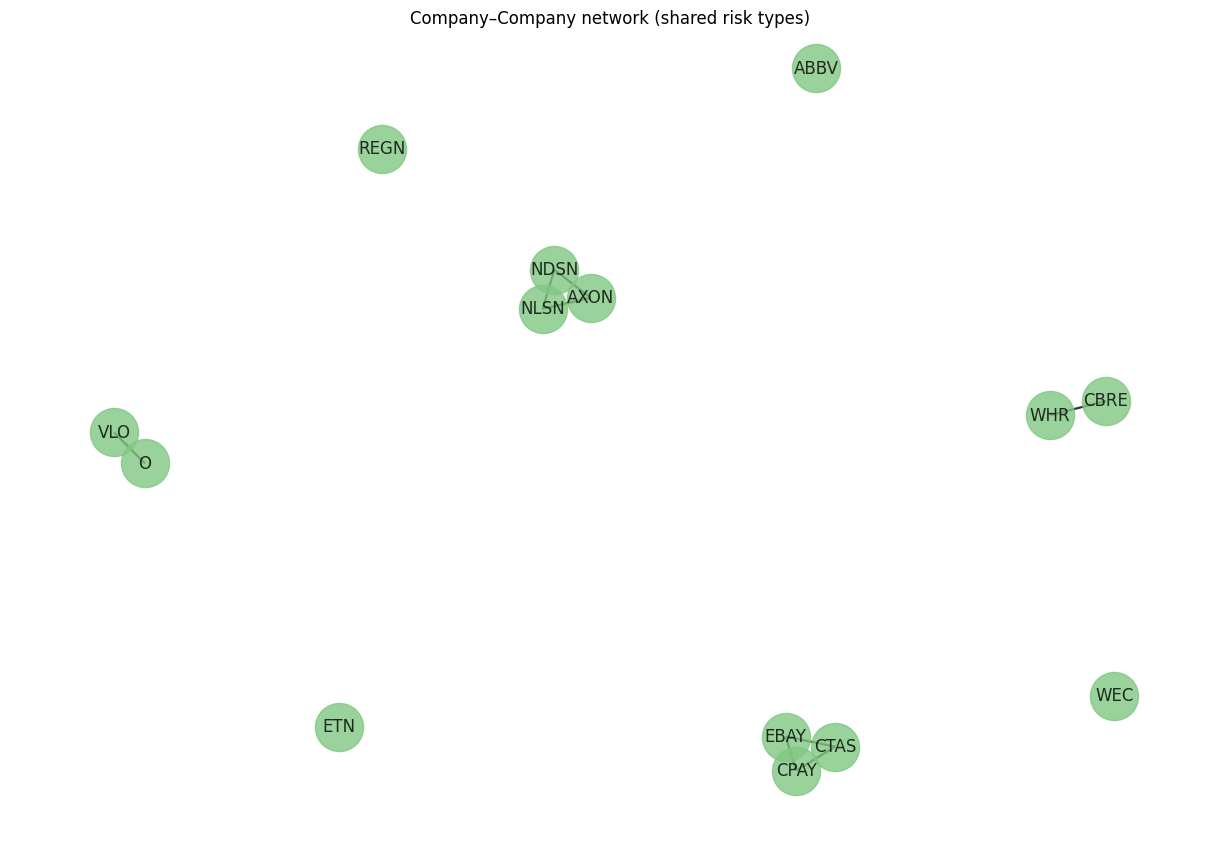

In [19]:
from networkx.algorithms import bipartite

companies_only = [n for n,d in Gw.nodes(data=True) if d["type"]=="company"]
risks_only     = [n for n,d in Gw.nodes(data=True) if d["type"]=="risk"]

# Weighted projection: edge weight = number of shared risks
Cc = bipartite.weighted_projected_graph(Gw, companies_only)

print(f"Company–Company projection: {Cc.number_of_nodes()} nodes, {Cc.number_of_edges()} edges")

# Top neighbours by shared risks
deg = sorted(Cc.degree(weight="weight"), key=lambda x: x[1], reverse=True)[:10]
print("Top companies by shared-risk connectivity:", deg)

# Plot
plt.figure(figsize=(12,8))
pos = nx.spring_layout(Cc, seed=7)
ew = [0.8 + 0.8*Cc[u][v]["weight"] for u,v in Cc.edges()]
nx.draw(Cc, pos, with_labels=True, node_color="#81C784", node_size=1200, width=ew, alpha=0.8)
plt.title("Company–Company network (shared risk types)")
plt.axis("off"); plt.tight_layout(); plt.show()


,Before 2022,2022 and later
risk_type_norm,,
business uncertainty,0,1
financial,4,0
financial performance,1,0
general,1,0
general business / forward-looking statement,1,0
general business risk,2,1
general business/financial,1,0
market,1,1
market/competitive,1,0


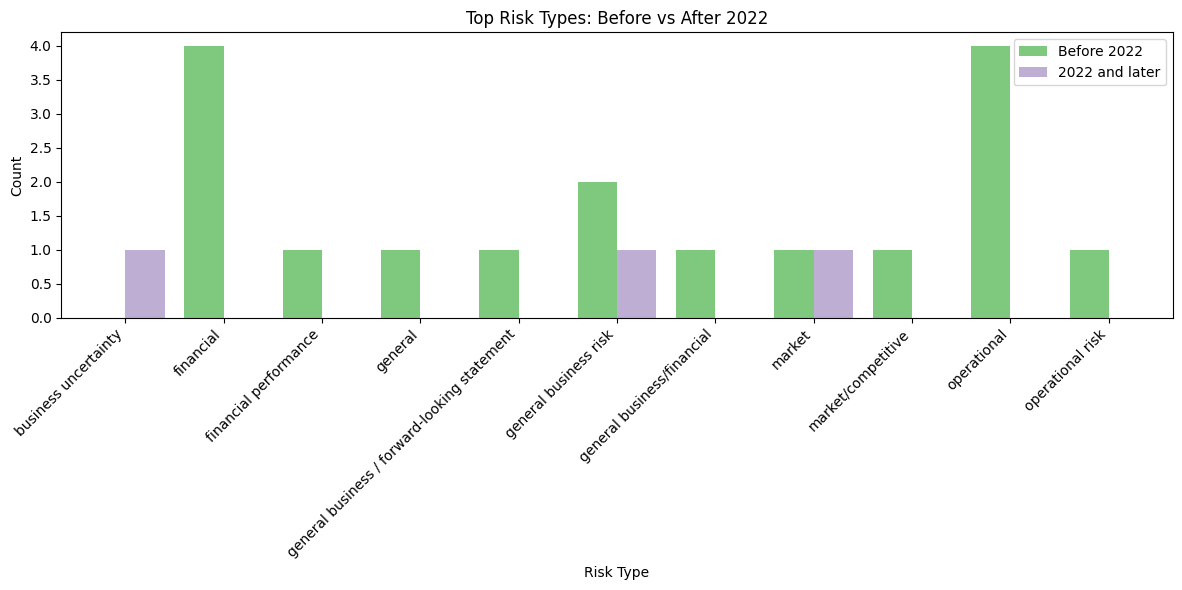

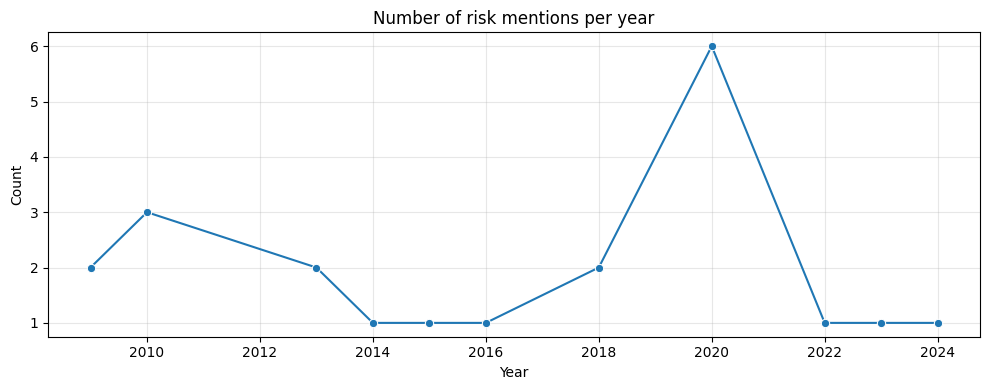

In [20]:
if "year" in df_risks.columns and df_risks["year"].notna().any():
    df_time = df_risks.dropna(subset=["year"]).copy()
    df_time["year"] = df_time["year"].astype(int)

    # Before vs after 2022
    before = df_time[df_time["year"] < 2022]
    after  = df_time[df_time["year"] >= 2022]

    top_b = before["risk_type_norm"].value_counts().head(10)
    top_a = after["risk_type_norm"].value_counts().head(10)

    comp = pd.DataFrame({"Before 2022": top_b, "2022 and later": top_a}).fillna(0).astype(int)
    display(comp)

    ax = comp.plot(kind="bar", figsize=(12,6), width=0.8, color=["#7FC97F","#BEAED4"])
    ax.set_title("Top Risk Types: Before vs After 2022")
    ax.set_xlabel("Risk Type"); ax.set_ylabel("Count")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

    # Trend over time
    yearly_counts = df_time.groupby("year")["risk_type_norm"].count()
    plt.figure(figsize=(10,4))
    sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker="o")
    plt.title("Number of risk mentions per year"); plt.xlabel("Year"); plt.ylabel("Count")
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

else:
    print("⚠️ No 'year' available for time analysis.")


In [21]:
from IPython.display import Markdown
Markdown("""
### Limitations (LLM Extraction)
- Some **hallucinated** risk labels (over-general categories).
- **Boundary errors**: occasionally merges two sentences or misses implicit risks.
- **Schema sensitivity**: JSON sometimes inconsistent — handled by cleaning.
- **Subset size**: runtime constraints limit coverage; results illustrate method rather than population truth.

**Mitigations:** pre-filtering with spaCy to reduce tokens; normalized risk types; used weighted edges and projections; documented manual inspection.
""")



### Limitations (LLM Extraction)
- Some **hallucinated** risk labels (over-general categories).
- **Boundary errors**: occasionally merges two sentences or misses implicit risks.
- **Schema sensitivity**: JSON sometimes inconsistent — handled by cleaning.
- **Subset size**: runtime constraints limit coverage; results illustrate method rather than population truth.

**Mitigations:** pre-filtering with spaCy to reduce tokens; normalized risk types; used weighted edges and projections; documented manual inspection.


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import networkx as nx

# --- Helper function to save figures ---
saved_figures = []
saved_files = []

def save_fig(fig, name):
    """Save a matplotlib figure as PNG and track it."""
    filename = f"{name}.png"
    fig.savefig(filename, bbox_inches='tight')
    plt.close(fig)  # close figure to avoid clutter
    saved_figures.append(filename)
    print(f"✅ Saved figure: {filename}")

# ============================
# 1. Semantic clustering scatter
fig, ax = plt.subplots(figsize=(10,6))
for cluster in range(n_clusters):
    idxs = cluster_labels == cluster
    ax.scatter(
        embedding_2d[idxs, 0],
        embedding_2d[idxs, 1],
        label=f"Cluster {cluster}",
        alpha=0.7,
        s=50
    )
ax.set_title("Semantic Clustering of Extracted Risk Sentences")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.legend()
plt.tight_layout()
save_fig(fig, "semantic_clustering")

# 2. Company-Risk network (top 25)
fig, ax = plt.subplots(figsize=(14,10))
pos = nx.spring_layout(G, seed=42)
node_colors = ['lightgreen' if G.nodes[n].get('type')=='company' else 'skyblue' for n in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1500, font_size=10, ax=ax)
ax.set_title("Company-Risk Network (Top 25 Risk Types)")
save_fig(fig, "company_risk_network_top25")

# 3. Top risk types and categories
fig, ax = plt.subplots(figsize=(10,5))
top_types.plot(kind="barh", ax=ax)
ax.set_title("Top risk types (normalized)")
ax.set_xlabel("Count"); ax.set_ylabel("Risk type")
plt.tight_layout()
save_fig(fig, "top_risk_types")

fig, ax = plt.subplots(figsize=(7,4))
top_cats.plot(kind="bar", ax=ax)
ax.set_title("Risk categories")
ax.set_xlabel("Category"); ax.set_ylabel("Count")
plt.tight_layout()
save_fig(fig, "risk_categories")

# 4. Weighted bipartite network
fig, ax = plt.subplots(figsize=(14,10))
pos = nx.spring_layout(Gw, seed=42, k=0.6)
node_colors = ["#81C784" if Gw.nodes[n]["type"]=="company" else "#64B5F6" for n in Gw.nodes()]
edge_ws = [0.6 + 0.6*Gw[u][v]["weight"] for u,v in Gw.edges()]
nx.draw_networkx_nodes(Gw, pos, node_color=node_colors, node_size=1200, ax=ax)
nx.draw_networkx_labels(Gw, pos, font_size=9, ax=ax)
nx.draw_networkx_edges(Gw, pos, width=edge_ws, alpha=0.6, ax=ax)
ax.set_title("Company–Risk bipartite network (weighted)")
ax.axis("off")
plt.tight_layout()
save_fig(fig, "weighted_bipartite_network")

# 5. Company-Company network
fig, ax = plt.subplots(figsize=(12,8))
pos = nx.spring_layout(Cc, seed=7)
ew = [0.8 + 0.8*Cc[u][v]["weight"] for u,v in Cc.edges()]
nx.draw(Cc, pos, with_labels=True, node_color="#81C784", node_size=1200, width=ew, alpha=0.8, ax=ax)
ax.set_title("Company–Company network (shared risk types)")
ax.axis("off")
plt.tight_layout()
save_fig(fig, "company_company_network")

# 6. Time analysis (if 'year' column exists)
if "year" in df_risks.columns and df_risks["year"].notna().any():
    df_time = df_risks.dropna(subset=["year"]).copy()
    df_time["year"] = df_time["year"].astype(int)

    # Before vs after 2022
    before = df_time[df_time["year"] < 2022]
    after  = df_time[df_time["year"] >= 2022]

    top_b = before["risk_type_norm"].value_counts().head(10)
    top_a = after["risk_type_norm"].value_counts().head(10)

    comp = pd.DataFrame({"Before 2022": top_b, "2022 and later": top_a}).fillna(0).astype(int)
    display(comp)

    fig, ax = plt.subplots(figsize=(12,6))
    comp.plot(kind="bar", width=0.8, color=["#7FC97F","#BEAED4"], ax=ax)
    ax.set_title("Top Risk Types: Before vs After 2022")
    ax.set_xlabel("Risk Type"); ax.set_ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    save_fig(fig, "top_risk_types_before_after_2022")

    # Trend over time
    yearly_counts = df_time.groupby("year")["risk_type_norm"].count()
    fig, ax = plt.subplots(figsize=(10,4))
    sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker="o", ax=ax)
    ax.set_title("Number of risk mentions per year")
    ax.set_xlabel("Year"); ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    save_fig(fig, "risk_mentions_per_year")

else:
    print("⚠️ No 'year' available for time analysis.")

# -----------------------------
# Save CSV separately
df_risks.to_csv("risks_extracted.csv", index=False)
saved_files.append("risks_extracted.csv")
print("✅ Saved CSV: risks_extracted.csv")

# -----------------------------
import zipfile
from google.colab import files

# --- Create a ZIP archive ---
zip_filename = "risks_analysis_files.zip"

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Add all figures
    for f in saved_figures:
        zipf.write(f)
    # Add CSVs
    for f in saved_files:
        zipf.write(f)

print(f"✅ Created ZIP archive: {zip_filename}")

# --- Download the ZIP ---
files.download(zip_filename)


✅ Saved figure: semantic_clustering.png
✅ Saved figure: company_risk_network_top25.png
✅ Saved figure: top_risk_types.png
✅ Saved figure: risk_categories.png
✅ Saved figure: weighted_bipartite_network.png
✅ Saved figure: company_company_network.png
⚠️ No 'year' available for time analysis.
✅ Saved CSV: risks_extracted.csv
✅ Created ZIP archive: risks_analysis_files.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This cell saves the extracted risks in a cvs file and exports all the visualization as an image file to a zip file (risks_analysis_files.zip) These files can be included in the project deliverables or uploaded to GitHub for documentation and reproducibility.

In [23]:
!pip freeze > requirements.txt


In [38]:
from google.colab import files

# Download the requirements.txt file
files.download("requirements.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>